In [1]:
%run ../src/game.py
%run ../src/ipd.py
%run ../src/strategies.py
%run ../src/tools.py
dip =[(3,3),(0,5),(5,0),(1,1)]   # Dilemme du prisonnier



# Evaluation par synthèse de sous-classes

Les compétitions écologiques offrent un outil de mesure assez fiable de la robustesse d'une stratégies, mais encore insuffisant. Il se peut par exemple que certaines stratégies se sacrifient pour d'autres dans un schema *maitre-esclave*. Avoir une synthèse de centaines voir de milliers de compétitions écologiques dans lesquelles on a enlevé certaines stratégies mesure sans doute une meilleure robustesse. L'une des idées les plus simples consiste à calculer les n compétitions possibles que l'on peut faire en enlevant 1 stratégie à un ensemble de n stratégies. On appelle cette technique la technique des sous-classes.
Nous définissions ici 3 fonctions permettant de réaliser ces sous-classes.
- `subclasses(bag, n)` qui évalue tous les sous ensembles possibles de taille n dans la bage
- `subclassesWithOneStrat(bag, n, strat)` qui évalue Strat dans tous les sous ensembles possibles de taille n dans le `bag` en ajoutant systématiquement la stratégie `strat`
- `subclassesRandomWithOneStrat(p, bag, n, Strat)` qui réalise p competitions de n strategies choisies au hasard dans la bage dans lesquelles on rajoute systématiquement Strat

Les évaluations réalisées dans ces fonctions sont des compétitions écologiques.

Ces fonctions renvoient à la fin un tableau avec pour chaque stratégie, sa meilleure place, sa pire place, sa moyenne et son écart-type.

#### Un cas simple : toutes les compétitions de 3 stratégies parmi les classiques

In [ ]:
All_C = Periodic('C')
All_D = Periodic('D')
bag = [All_C, All_D, Tft(), Spiteful(), Gradual(), SoftMajority(), HardMajority()]
subClasses(bag, 3)

#### Un cas plus volumineux : toutes les stratégies Mem(1,1) avec une stratégie en moins à chaque fois
Sachant qu'il y a 32 `mem(1,1)` cette opération réalise donc 32 compétitions de 31 stratégie. Notez que dans le cas de cette méthode, toutes les stratégies sont présentes (et absentes) exactement le même nombre de fois.


In [ ]:
import time
before = time.time()
bag = getAllMemory(1,1)
subClasses(bag, len(bag)-1)
after = time.time()
print("Time : {}".format(after-before))

#### Test de la stratégie Spiteful avec tous les triplets de classiques
Dans les cas des deux méthodes `subClassesWithOneStrat` seule la stratégie passée en paramètre participe à toutes les sous-classes (faisable pour des ensembles pas trop volumineux genre `mem(1,1)`). Dans la première elle participe à la totalité des sous-classes tandis qu'avec `subClassesRandomWithOneStrat` elle participe à un nombre fixé de sous classes de même taille mais prises aléatoirement (utilisable dans de gros ensembles comme `mem(2,2)`).

In [ ]:
All_C = Periodic('C')
All_D = Periodic('D')
bag = [All_C, All_D, Tft(), Gradual(), SoftMajority(), HardMajority()]
res  = subClassesWithOneStrat(bag, 3, Spiteful())
#Pour afficher le tableau en entier : 
#res = subClassesWithOneStrat(bag, 3, Spiteful(), True)

Il est à noter que les objets `subClassesWithOneStrat` et `subClassesRandomWithOneStrat` conservent le 
meilleur et le pire des tournois pour la stratégie `strat`
Au moment de l'affichage du classement des sous-classes il est de ce fait possible d'afficher l'ensemble de stratégies qui a été favorable ou défavorable à la stratégie `Strat`.

In [ ]:
meilleureComp, pireComp, strategy = res
print("La meilleure competition pour la stratégie "+strategy.name +" est : ")
for strat in meilleureComp :
    print(strat.name)

#### 100 experiences de 10 stratégies prise au hasard dans mem(2,2) contre Gradual()
Pour les `subclassesRandom`, si une stratégie n'a joué qu'une seule fois alors elle n'a pas d'écart-type (`NaN`); si elle n'a pas joué du tout alors toutes ses valeurs sont à `NaN` dans le tableau

In [ ]:
bag = getAllMemory(2,2)
res = subClassesRandomWithOneStrat(100,bag, 10, Gradual())
#Pour afficher le tableau en entier : 
#subClassesRandomWithOneStrat(100, bag, 10, Gradual(), True)


On peut d'ailleurs vérifier la compétition la plus "défavorable" à Gradual 
(comme c'est un choix aléatoire, donc 2 éxécutions ne donneront pas systématiquement le même résultat)

In [ ]:
bestComp, worstComp, strategy = res

In [ ]:
bag = worstComp
e2=Ecological(g,bag)
e2.run()
e2.drawPlot(None,None)
evol=e2.historic
print(evol.iloc[-1])
print(e2.historic.iloc[e2.generation].rank(0, method="min", ascending=False))

## Conception d'une méta-stratégie

Une méta-stratégie est une stratégie composée de plusieurs stratégies. 
Dans un premier temps, chaque sous-stratégie joue pendant n tours puis on comptabilise le nombre de points obtenu par ces sous-stratégies pendant ces n tours.
On choisit ensuite pour les `n` tours suivants, la stratégie qui a obtenu le plus de points sur cette période. On recommence la même procédure de choix d'une souss-stratégie tous les multiples de `n`.

La classe `MetaStrategy(liste des stratégies, n)` permet de définir un tel fonctionnement.

In [ ]:
# check of MetaStrategy : the two results should be the same

# with Metastrat
metaStrat = MetaStrategy([Tft()], 5)
bag = getMem(1,1)
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat)

# without Metastrat
res  = subClassesWithOneStrat(bag,len(bag)-1, Tft())


In [ ]:
# check of MetaStrategy : the two results should be the same (with a Periodic)

metaStrat = MetaStrategy([Periodic("CCD")], 5)
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat)

res  = subClassesWithOneStrat(bag,len(bag)-1, Periodic("CCD"))

### Tests de méta-stratégies
Grâce à cet outil il est alors possible de chercher à concevoir la meilleure meta-stratégie contre Memory(1,1) + Gradual.
On réalise pour cela différents tests durant lesquels on change : 
- les stratégies
- le nombre de tours n.

Afin d'assurer un certaine robustesse, on peut utiliser le calcul de sous-classes `subClassesWithOneStrat` qui, pour une stratégie particulière (ici, notre meta-stratégie) fait plusieurs compétitions écologiques et mesure le meilleur rang, le pire rang, le rang moyen, et l'écart-type qu'elle obtient.

In [ ]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 5)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)



In [ ]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 4)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)


In [ ]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 3)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)


In [ ]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 2)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)


In [ ]:
metaStrat = MetaStrategy([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")], 1)
bag = getMem(1,1)+[Gradual()]

# Test avec les sous-classes
# res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)

# Test avec un tournoi
# t = Tournament(g,[metaStrat]+bag)
# t.run()
# print(t.matrix)
# print(t.matrix['Total'])

# Test avec une competition écolo
e = Ecological(g,[metaStrat]+bag)
e.run()
e.drawPlot(None,10)
#print(e.score)

In [ ]:
metaStrat = MetaStrategy([Tft(), Spiteful(), Gradual()], 3)
bag = getMem(1,1)+[Gradual()]
res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)

On constate ici que la meilleure méta-stratégie que l'on arrive à concevoir est la Méta-stratégie composée des stratégies Tft(), Periodic('C'), Spiteful(), Periodic('CCD') avec un n=2 ou n=1.
Verifions maintenant si cette séquence de stratégies est optimal en testant toutes les séquences possibles

In [ ]:
bag = getMem(1,1)+[Gradual()]
all = itertools.permutations([Tft(), Periodic("C"), Spiteful(), Periodic("CCD")])
for a in all : 
    print("Ordre")
    for strat in a : 
        print(strat.name)
    metaStrat = MetaStrategy(a, 2)
    res  = subClassesWithOneStrat(bag,len(bag)-1, metaStrat, length = 100)
    

Après cette vérification les séquences de stratégies qui fournissent les moins bons résultats sont les séquences commençant par Periodic('CCD'), toutes les autres fournissent un meilleur résultat.


## Tests d'équivalence de stratégies

Les ensembles de stratégies que nous traitons sont parfois redondants : il contiennent les mêmes stratégies écrites de différentes manières. Il semble donc interessant de pouvoir simplifier des ensembles de stratégies en suprimant les doublons qu'ils peuvent contenir. 
Malheureusement, chacun le sait depuis Turing, l'équivalence de deux programmes est indécidable. Il n'y a donc pas de test parfait. Il est néanmoins possible de fournir des outils permettant d'avancer dans ce problème de simplification.


Pour savoir si deux stratégies sont différentes, il suffit de les faire jouer contre une stratégie de référence et s'assurer qu'elles jouent différemment face à cet adversaire. Evidemment selon la complexité de cette stratégie de référence, le test est plus ou moins efficace. Si les stratégies jouent la même chose, cela ne fournit néanmoins pas une preuve de leur équivalence. Ce test est semi-décidable : si les stratégies jouent différemment il est sûr qu'elles sont différentes, mais si elles jouent de manière identique, c'est peut-etre que la stratégie de référence n'a pas sû révéler leur différence de comportement.
La fonction `testEquivUnit` réalise ce test. On lui passe un couple de stratégies à tester et uen stratégie de référence `opponent`, et elle compare ces deux stratégies durant `length` tours d'un meeting. Elle renvoie un booléen : équivalent (avec doute) ou pas.

In [6]:
def testEquivUnit(strategies, opponent, length):
    res = []
    for strat in strategies :
        m = Meeting(g, strat, opponent, length)
        m.run()
        res += [' '.join(map(str, m.s1_rounds)) ] 
    return len(set(res)) == 1


print(testEquivUnit((Tft(), Spiteful())  , Periodic("CCDCD"), 100))
print(testEquivUnit((Tft(), Mem(0,1,"cCD")),  Periodic("CCDCD"), 100))


False
True


Le choix de la stratégie de référence est capital. Si elle est trop "faible", elle ne permet pas aux deux stratégies comparées de se "révéler" et indique alors qu'elles sont équivalentes alors qu'elles ne le sont pas, comme ci-dessous : Tft et Spiteful sont clairement différentes, et pourtant, face à All_C elles ont le même comportement.


In [7]:
testEquivUnit((Tft(), Spiteful()), Periodic('C'), 100)

True

Un test plus robuste pourrait être de les faire jouer contre `Periodic('CCD')`. Cette dernière permet à Tft et Spiteful de révéler leeur véritable comportement. On a cette fois ci la preuve que ces deux stratégies ne sont pas équivalentes.

In [8]:
testEquivUnit((Tft(), Spiteful()), Periodic('CD'), 100)

False

Afin d'améliorer cette comparaison de deux stratégies, il est préférable de les comparer non pas à une seule stratégie de référence, mais à un ensemble de stratégies de référence. On compare nos deux stratégies contre chaque élément de cet ensemble, ce qui constitue un test surement plus robuste. Bien évidemment dès que l'une de celles-ci indique une différence entre deux 2 stratégies, le test peut s'arrêter.
La fonction `testEquivMultiple` fonctionne comme précédemment, mais cette fois en cherchant à trouver une différence de comportement grâce à une liste d'opposants. Comme précédemmnt elle renvoie un booléen : équivalent (avec doute) ou pas.

In [9]:
def testEquivMultiple(strategies, opponents, length):
    for opponent in opponents : 
        equiv = testEquivUnit(strategies, opponent, length)
        if equiv == False :
            return False
    return True

testEquivMultiple((Tft(), Spiteful()),[Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)

False

Pour simplifier un ensemble de stratégies, il suffit maintenant d'effectuer le test précédent sur tous les couples possibles. Les stratégies identifiées comme potentiellement équivalentes sont alors regroupées.
la fonction `classesEquiv(l, opponents, length)` effectue ce test sur l'ensemble `l`. Elle renvoie dans un dictionnaire les classes d'équivalence identifiées.
Par exemple si on a strat1 équivalente à strat2 ainsi que strat3 qui elle n'a pas d'équivalente, la fonction va renvoyer un dictionnaire : `{strat1 : [strat2] , strat3 : []}`

L'ensemble des clés de ce disctionnaire constitue l'ensemble de stratégies simplifié, et chaque entrée du dictionnaire correspond à un ensemble de stratégies équivalentes.

In [10]:
def classesEquiv(l, opponents, length):
    m = dict()
    while len(l) > 0 :
        m[l[0]] = []
        ind = [0]
        for j in range(len(l[1:])):
            if testEquivMultiple([l[0], l[j + 1]], opponents, length):
                m[l[0]] += [l[j + 1]]
                ind += [j + 1]
        ltmp = []
        for i in range(len(l)):
            if i not in ind :
                ltmp += [l[i]]
        l = ltmp
    return m


# This function allows you to display the names of the strategies instead of the instance number.
def printCe(ce):
    for key in ce.keys() :
        if len(ce[key]) > 0:
            print("\n" + key.name + " : " , end =" " )
        else :
            print("\n"+ key.name + ": []"  , end =" ")
        for value in ce[key]:
            print(value.name , end =" ")
    print(" ")
    
    
L = [Tft(), Spiteful(), Mem(0,1,"cCD"),  Mem(1,1,"cCDDD"), Periodic("CDC") ]
ce = classesEquiv(L, [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
printCe(ce)
print("Simplified set size : " + str(len(ce.keys())))


tft :  cCD 
spiteful :  cCDDD 
per_CDC: []  
Simplified set size : 3


On rappelle que la qualité de cette simplification dépend très fortement de la qualité de la liste de référence. On le constate aisément en tentant de simplifier `mem(1,2)` face à une liste de plus en plus grande de stratégies de référence.


In [12]:
# Mem(1,2) contains 1024 strategies

# Without any opponent, they are all considered equivalent.
ce = classesEquiv(getMem(1,2), [], 10)
print(len(ce.keys()))

# Comparing with simply ALL_C , only 9 different strategies are available
ce = classesEquiv(getMem(1,2), [Periodic('C')], 10)
print(len(ce.keys()))

# We're gradually strengthening the test
ce = classesEquiv(getMem(1,2), [Periodic('C'), Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
print(len(ce.keys()))

ce = classesEquiv(getMem(1,2), [Periodic('C'), Periodic('CDCCDDC'), Periodic('DDCDCDD'),Gradual()], 10)
print(len(ce.keys()))

# So? How large is this simplified set really?


1
12
712
728


On peut encore renforcer le test en commençant par faire jouer toutes les stratégies de l'ensemble à tester entre elles. Bien évidemment si des stratégies sont identiques, elles doivent avoir le même score dans ce tournoi. On peut donc se contenter de tester les équivalences sur les ensembles de stratégies qui obtiennent en Tournoi un score identique. Rajouter cette équivalence des scores renforce encore un peu plus notre test.
Bien évidemment ceci se fait au détriment du temps de calcul.
La fonction `simplify` effectue ce travail. Elle fonctionne comme précédemment mais démarre par un tournoi afin d'identifier les paquets de stratégies ayant le même score. On concatène ensuite chacun des dictionnaires

In [22]:
def simplify(l, opponents, length):
    scores = dict()
    t = Tournament(g, opponents + l, length)
    t.run()
    res = t.matrix['Total']
    for strat in l : 
        score = res[strat.name]
        if score not in scores :
            scores[score] = [strat]
        else : 
            scores[score] += [strat]
    
    d = dict()
    for item in scores.values():
        if len(item) > 1 :
            res = classesEquiv(item, opponents, length)
            for it in res.keys():
                if len(res[it]) > 0 :
                    d[it] = res[it]
        else : 
            d[item[0]] = []
    return d

        
    
        
strats = simplify(getMem(1,2), [Periodic('C'), Periodic('CDCCDDC'), Periodic('DDCDCDD'),Gradual()], 10)
print("Simplified set size : " + str(len(strats)))

# RECORD BROKEN! 820... but this test remains undecidable, it is nevertheless subject to a doubt... 
        
    

Simplified set size : 752

CCCCCCCCCC :  CCCCCCCCCD CCCCCCCCDC CCCCCCCCDD CCCCCCCDCC CCCCCCCDCD CCCCCCCDDC CCCCCCCDDD CCCCCCDCCC CCCCCCDCCD CCCCCCDCDC CCCCCCDCDD CCCCCCDDCC CCCCCCDDCD CCCCCCDDDC CCCCCCDDDD 
CCCCCDCCCC :  CCCCCDCCDC CCCCCDDCCC CCCCCDDCDC 
CCCCCDCCCD :  CCCCCDCCDD CCCCCDDCCD CCCCCDDCDD 
CCCCCDCDCC: [] 
CCCCCDCDCD: [] 
CCCCCDCDDC: [] 
CCCCCDCDDD: [] 
CCCCCDDDCC: [] 
CCCCCDDDCD: [] 
CCCCCDDDDC: [] 
CCCCCDDDDD: [] 
CCCCDCCCCC :  CCCCDCCCDC CCCCDCDCCC CCCCDCDCDC 
CCCCDCCCCD :  CCCCDCCCDD CCCCDCDCCD CCCCDCDCDD 
CCCCDCCDCC: [] 
CCCCDCCDCD: [] 
CCCCDCCDDC: [] 
CCCCDCCDDD: [] 
CCCCDCDDCC: [] 
CCCCDCDDCD: [] 
CCCCDCDDDC: [] 
CCCCDDCCCC :  CCCCDDCCDC CCCCDDDCCC CCCCDDDCDC 
CCCCDDCCCD :  CCCCDDCCDD CCCCDDDCCD CCCCDDDCDD 
CCCCDDCDCC: [] 
CCCCDDCDCD: [] 
CCCCDDCDDC: [] 
CCCCDDCDDD: [] 
CCCCDDDDCC: [] 
CCCCDDDDCD: [] 
CCCCDDDDDC: [] 
CCCCDDDDDD: [] 
CCCDCCCCCC :  CCCDCCCCCD CCCDCCCDCC CCCDCCCDCD 
CCCDCCCCDC: [] 
CCCDCCCCDD: [] 
CCCDCCCDDC: [] 
CCCDCCCDDD: [] 
CCCDCCDCCC :  CCCDCCDCCD 

### Tableau de synthèse

Etant donnée une base de comparaison, réaliser un tableau contenant pour chacune des classes de Memory classiques, la synthèse des tailles obtenues après simplication via ClassesEquiv et simplification via Simplify 

In [25]:
base  = [Periodic('CDCCDDC'), Periodic('DDCDCDD'),Gradual()]

Mem01 = getMem(0,1)
Mem10 = getMem(1,0)
Mem11 = getMem(1,1)
Mem12 = getMem(1,2)
Mem21 = getMem(2,1)

ce01 = classesEquiv(Mem01, base, 10)
ce10 = classesEquiv(Mem10, base, 10)
ce11 = classesEquiv(Mem11, base, 10)
ce12 = classesEquiv(Mem12, base, 10)
ce21 = classesEquiv(Mem21, base, 10)

simp01 = simplify(Mem01, base, 10)
simp10 = simplify(Mem10, base, 10)
simp11 = simplify(Mem11, base, 10)
simp12 = simplify(Mem12, base, 10)
simp21 = simplify(Mem21, base, 10)

# idem avec simplify

tab = pd.DataFrame(
        np.nan, ["Mem 0 1","Mem 1 0","Mem 1 1", "Mem 1 2", "Mem 2 1"], ["All strategies", "After classesEquiv","After simplify"]
    )
tab.at["Mem 0 1", "All strategies" ] = len(Mem01)
tab.at["Mem 1 0", "All strategies" ] = len(Mem10)
tab.at["Mem 1 1", "All strategies" ] = len(Mem11)
tab.at["Mem 1 2", "All strategies" ] = len(Mem12)
tab.at["Mem 2 1", "All strategies" ] = len(Mem21)
tab.at["Mem 0 1", "After classesEquiv" ] = len(ce01.keys())
tab.at["Mem 1 0", "After classesEquiv" ] = len(ce10.keys())
tab.at["Mem 1 1", "After classesEquiv" ] = len(ce11.keys())
tab.at["Mem 1 2", "After classesEquiv" ] = len(ce12.keys())
tab.at["Mem 2 1", "After classesEquiv" ] = len(ce21.keys())
tab.at["Mem 0 1", "After simplify" ] = len(simp01)
tab.at["Mem 1 0", "After simplify" ] = len(simp10)
tab.at["Mem 1 1", "After simplify" ] = len(simp11)
tab.at["Mem 1 2", "After simplify" ] = len(simp12)
tab.at["Mem 2 1", "After simplify" ] = len(simp21)
tab

,All strategies,After classesEquiv,After simplify
Mem 0 1,8.0,8.0,6.0
Mem 1 0,8.0,6.0,6.0
Mem 1 1,32.0,26.0,26.0
Mem 1 2,1024.0,639.0,744.0
Mem 2 1,1024.0,465.0,574.0


Petite vérification

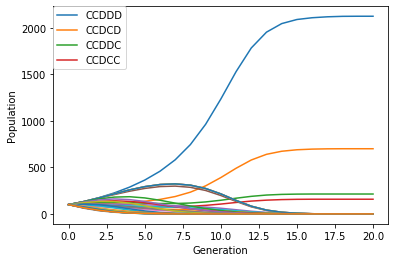

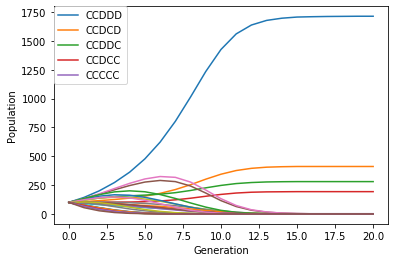

In [36]:
simpl = simplify(getMem(1,1), [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
e1 = Ecological(g, getMem(1,1))
e1.run()

evol=e1.historic
nbSurvivors = len(evol.iloc[-1][evol.iloc[-1]>0])
e1.drawPlot(None,nbSurvivors)


e2 = Ecological(g, list(simpl.keys()))
e2.run()

evol=e2.historic
nbSurvivors = len(evol.iloc[-1][evol.iloc[-1]>0])
e2.drawPlot(None,nbSurvivors)





In [39]:
def trie_Mem(strategies):
    strategies.sort(key=lambda x: x.genome)
    return strategies


sortMem11 = trie_Mem(getMem(1,1))
for s in sortMem11:
    print(s.genome)

CCCCC
CCCCD
CCCDC
CCCDD
CCDCC
CCDCD
CCDDC
CCDDD
CDCCC
CDCCD
CDCDC
CDCDD
CDDCC
CDDCD
CDDDC
CDDDD
DCCCC
DCCCD
DCCDC
DCCDD
DCDCC
DCDCD
DCDDC
DCDDD
DDCCC
DDCCD
DDCDC
DDCDD
DDDCC
DDDCD
DDDDC
DDDDD


In [44]:
def rec_simplify(l, opponents, length, batchSize):
    size = len(l)
    strats = []
    simplified = set()
    for i in range(int(size/batchSize)):
        strats += l[i * batchSize : (i+1) * batchSize]
        res = simplify(strats, opponents, length)
        print("{} strategies deleted".format(len(strats) - len(res)))
        for strat in res.keys() :
            simplified.add(strat)
        strats = list(simplified)
    return simplified


        
print(rec_simplify([Tft(), Spiteful(), Mem(0,1,"cCD"),  Mem(1,1,"cCDDD"), Periodic("CDC"), Periodic('C') ], [Periodic('CCD'), Periodic('DDC')] , 10, 2))
print(" ")
sortMem12 = trie_Mem(getMem(1,2))
rec_simplify(sortMem12, [Periodic('CCD'), Periodic('DDC')] , 10, 32)

0 strategies deleted
2 strategies deleted
0 strategies deleted
{<__main__.Spiteful object at 0x7fd1ae2549b0>, <__main__.Periodic object at 0x7fd1ae261e48>, <__main__.Tft object at 0x7fd1ae2541d0>, <__main__.Periodic object at 0x7fd1ae2548d0>}
 
27 strategies deleted
21 strategies deleted
34 strategies deleted
40 strategies deleted
10 strategies deleted
15 strategies deleted
13 strategies deleted
30 strategies deleted
25 strategies deleted
27 strategies deleted
28 strategies deleted
27 strategies deleted
27 strategies deleted
36 strategies deleted
29 strategies deleted
47 strategies deleted
47 strategies deleted
57 strategies deleted
54 strategies deleted
46 strategies deleted
46 strategies deleted
61 strategies deleted
64 strategies deleted
42 strategies deleted
59 strategies deleted
71 strategies deleted
58 strategies deleted
76 strategies deleted
89 strategies deleted
82 strategies deleted
64 strategies deleted
86 strategies deleted


{<__main__.Mem at 0x7fd1ae0cb048>,
 <__main__.Mem at 0x7fd1d2f850f0>}

## Dilemme spatial (en cours)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random

# Input variables for the board
boardsize = 10   # board will be X by X where X = boardsize
my_board = np.empty((boardsize, boardsize), dtype=float)


# 0 : cooperator
# 1 : new cooperator
# 2 : defector   
# 3 : new defector


# Some helper functions
def init_strategies():
    strategies = np.zeros((boardsize, boardsize), dtype=object)
    for i in range(boardsize) :
        for j in range(boardsize):
            strategies[i, j] = 0
    strategies[5, 5] = 2
    return strategies
    
# Initialize the board with starting positions
# def strategies_to_board(strategies):
#     for i in range(boardsize) :
#         for j in range(boardsize) :
#             if strategies[i, j] == "C":
#                 my_board[i , j] = 0
#             else : 
#                 my_board[i, j] = 1
#     #print("-------------------------")
#     #print(strategies)
#     #print(my_board)
#     #print("--------------------------------")"
#     return my_board
    

# https://github.com/evoplex/model-prisonersDilemma
def update_strategies():
    scores = play()
    strategies = np.copy(update(scores))
    #print(strategies)
    return strategies

def play():
    scores = np.zeros((boardsize, boardsize))
    for i in range(boardsize):
        for j in range(boardsize):
            score = 0
            #cpt = 0
            score += getScore(strategies, i, j, i, j)
            if i >= 0 and j >= 0:
                score += getScore(strategies, i, j, i-1, j-1)
                #cpt += 1
            if j >= 0:
                score += getScore(strategies, i, j, i, j-1)
                #cpt += 1
            if i >= 0 :
                score += getScore(strategies, i, j, i-1, j)
                #cpt += 1
            if i < boardsize - 1 and j < boardsize - 1 :
                score += getScore(strategies, i, j, i+1, j+1)
                #cpt += 1
            if i < boardsize - 1 :
                score += getScore(strategies, i, j, i+1, j)
                #cpt += 1
            if j < boardsize -1 :
                score += getScore(strategies, i, j, i, j+1)
                #cpt += 1
            if i < boardsize - 1 and j >= 0:
                score += getScore(strategies, i, j, i+1, j-1)
                #cpt += 1
            if i >= 0 and j < boardsize - 1 :
                score += getScore(strategies, i, j, i-1, j+1)
                #cpt += 1
            scores[i][j] = score
    #print(scores)
    return scores

def update(scores):
    #print(scores)
    new_strategies = np.zeros((boardsize, boardsize), dtype=object)
    for i in range(boardsize):
        for j in range(boardsize):
            best = scores[i][j]
            ind_i = i 
            ind_j = j
            if i >= 0 and j >= 0:
                if scores[i-1][j-1] > best :
                    best = scores[i-1][j-1]
                    ind_i = i - 1
                    ind_j = j - 1
            if j >= 0:
                if scores[i][j-1] > best :
                    best = scores[i][j-1]
                    ind_i = i 
                    ind_j = j - 1
            if i >= 0 :
                if scores[i-1][j] > best :
                    best = scores[i-1][j]
                    ind_i = i - 1
                    ind_j = j 
            if i < boardsize - 1  and j < boardsize - 1 :
                if scores[i+1][j+1] > best :
                    best = scores[i+1][j+1]
                    ind_i = i + 1
                    ind_j = j + 1
            if i < boardsize - 1:
                if scores[i+1][j] > best :
                    best = scores[i+1][j]
                    ind_i = i + 1
                    ind_j = j 
            if j < boardsize - 1:
                if scores[i][j+1] > best :
                    best = scores[i][j+1]
                    ind_i = i 
                    ind_j = j + 1
            if i < boardsize - 1 and j >= 0:
                if scores[i+1][j-1] > best :
                    best = scores[i+1][j-1]
                    ind_i = i + 1
                    ind_j = j - 1
            if i >= 0 and j < boardsize - 1:
                if scores[i-1][j+1] > best :
                    best = scores[i-1][j+1]
                    ind_i = i - 1
                    ind_j = j + 1

                    
            # new cooperator
            if (strategies[i][j] > 1) and (strategies[ind_i][ind_j] < 2):
                new_strategies[i][j] = 1
            # new defector
            if (strategies[i][j] < 2) and (strategies[ind_i][ind_j] > 1):
                new_strategies[i][j] = 3
            else : 
                new_strategies[i][j] = strategies[ind_i][ind_j]
    return new_strategies
            

def getScore(strategies, i, j, k, l):
    s1 = strategies[i][j]
    s2 = strategies[k][l]
    res = binarize(s1) * 2 + binarize(s2)
    if res == 0:# CC 
        return 1
    elif res == 1 :# CD 
        return 0
    elif res == 2:# DC 
        return 1.9
    else :  # DD 
        return 0
    
def binarize(strategy):
    if strategy < 2:
        return strategy
    else :
        return strategy - 2


# def update_board(my_board):
#     strategies = np.copy(update_strategies())
#     print(strategies)
#     my_board = np.copy(strategies_to_board(strategies))
#     print(my_board)
#     return my_board




# Initialize the board
strategies = init_strategies()
print(strategies)
strategies = np.copy(update_strategies())
print(strategies)
# my_board = strategies_to_board(strategies)

##### Animate the board #####
# This will throw an error the first time you run the code, but the program will run properly if you
# execute the cell again (there is an error with the animation package that I cannot seem to get rid of)

# # Required line for plotting the animation
# %matplotlib notebook
# # Initialize the plot of the board that will be used for animation
# fig = plt.gcf()
# # Show first image - which is the initial board
# im = plt.imshow(my_board)
# plt.show()


# # Helper function that updates the board and returns a new image of
# # the updated board animate is the function that FuncAnimation calls
# def animate(frame):
#     im.set_data(update_board(my_board))
#     return im,

# # This line creates the animation
# anim = animation.FuncAnimation(fig, animate, interval=50)

## Bibliographie
- Evolutionary games and spatial chaos, Martin A. Nowak & Robert M. May 